<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
<center>
Автор материала: Юрий Кашницкий, программист-исследователь Mail.Ru Group <br> 

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 10 (демо)
## <center> Прогнозирование задержек вылетов

Ваша задача – побить единственный бенчмарк в [соревновании](https://www.kaggle.com/c/flight-delays-2017) на Kaggle Inclass. Подробных инструкций не будет, будет только тезисно описано, как получен этот бенчмарк. Конечно, с помощью Xgboost. Надеюсь, на данном этапе курса вам достаточно бросить полтора взгляда на данные, чтоб понять, что это тот тип задачи, в которой затащит Xgboost. Но проверьте еще Catboost.

<img src='../../img/xgboost_meme.jpg' width=40% />

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../../data/flight_delays_train.csv')
test = pd.read_csv('../../data/flight_delays_test.csv')

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
#gr['sum']
#df = train.copy()
df['dep_delayed_15min'] = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values

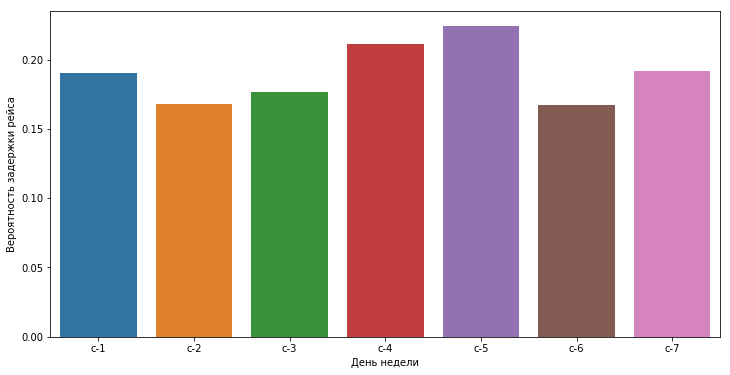

In [35]:
gr = df.groupby('DayOfWeek')['dep_delayed_15min'].agg(['sum', 'count'])
xs = gr.index.values
ys = gr['sum'] / gr['count']

plt.figure(figsize=(12, 6))
sns.barplot(xs, ys);

plt.xlabel('День недели');
plt.ylabel('Вероятность задержки рейса');

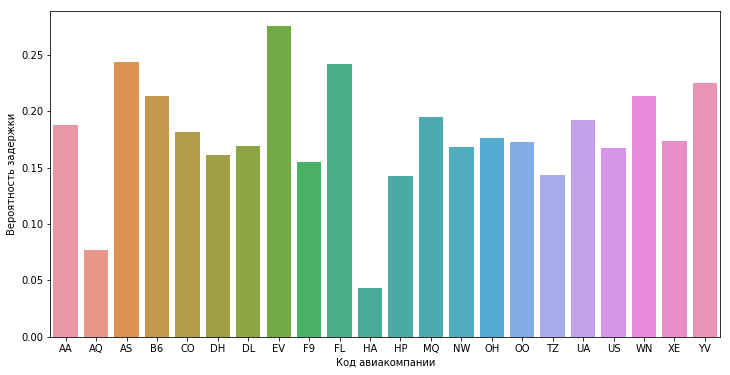

In [36]:
gr = df.groupby('UniqueCarrier')['dep_delayed_15min'].agg(['sum', 'count'])

plt.figure(figsize=(12, 6))
xs = gr.index.values
ys = gr['sum'] / gr['count']
sns.barplot(xs, ys);

plt.xlabel('Код авиакомпании');
plt.ylabel('Вероятность задержки');

Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. В качестве простейшего бенчмарка возьмем логистическую регрессию и два признака, которые проще всего взять: `DepTime` и `Distance`. У такой модели результат – 0.68202 на LB. 

In [6]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [7]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6789733731013721

In [8]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, 
          name='dep_delayed_15min').to_csv('logit_2feat.csv', 
                                           index_label='id', 
                                           header=True)

In [10]:
from catboost import Pool, CatBoostClassifier, cv

In [12]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    random_seed = 100,
    loss_function = 'MultiClass'
)

In [13]:
model.fit(X_train, y_train)

0:	learn: -0.6805491	total: 173ms	remaining: 2m 53s
1:	learn: -0.6686893	total: 272ms	remaining: 2m 15s
2:	learn: -0.6575030	total: 373ms	remaining: 2m 3s
3:	learn: -0.6469595	total: 479ms	remaining: 1m 59s
4:	learn: -0.6370050	total: 580ms	remaining: 1m 55s
5:	learn: -0.6276016	total: 680ms	remaining: 1m 52s
6:	learn: -0.6187031	total: 777ms	remaining: 1m 50s
7:	learn: -0.6103210	total: 952ms	remaining: 1m 58s
8:	learn: -0.6023519	total: 1.16s	remaining: 2m 8s
9:	learn: -0.5948352	total: 1.36s	remaining: 2m 14s
10:	learn: -0.5876807	total: 1.51s	remaining: 2m 16s
11:	learn: -0.5808999	total: 1.61s	remaining: 2m 12s
12:	learn: -0.5744775	total: 1.71s	remaining: 2m 10s
13:	learn: -0.5683669	total: 1.82s	remaining: 2m 8s
14:	learn: -0.5625824	total: 1.99s	remaining: 2m 10s
15:	learn: -0.5570825	total: 2.09s	remaining: 2m 8s
16:	learn: -0.5518478	total: 2.2s	remaining: 2m 7s
17:	learn: -0.5468801	total: 2.3s	remaining: 2m 5s
18:	learn: -0.5421606	total: 2.4s	remaining: 2m 3s
19:	learn: -0

155:	learn: -0.4458645	total: 18.7s	remaining: 1m 41s
156:	learn: -0.4458464	total: 18.8s	remaining: 1m 41s
157:	learn: -0.4458318	total: 18.9s	remaining: 1m 40s
158:	learn: -0.4458170	total: 19s	remaining: 1m 40s
159:	learn: -0.4458010	total: 19.1s	remaining: 1m 40s
160:	learn: -0.4457872	total: 19.2s	remaining: 1m 40s
161:	learn: -0.4457633	total: 19.3s	remaining: 1m 40s
162:	learn: -0.4457555	total: 19.4s	remaining: 1m 39s
163:	learn: -0.4457464	total: 19.5s	remaining: 1m 39s
164:	learn: -0.4457284	total: 19.6s	remaining: 1m 39s
165:	learn: -0.4457057	total: 19.7s	remaining: 1m 39s
166:	learn: -0.4456797	total: 19.8s	remaining: 1m 38s
167:	learn: -0.4456642	total: 19.9s	remaining: 1m 38s
168:	learn: -0.4456516	total: 20s	remaining: 1m 38s
169:	learn: -0.4456371	total: 20.1s	remaining: 1m 38s
170:	learn: -0.4456244	total: 20.2s	remaining: 1m 38s
171:	learn: -0.4456094	total: 20.3s	remaining: 1m 37s
172:	learn: -0.4455994	total: 20.4s	remaining: 1m 37s
173:	learn: -0.4455811	total: 20

309:	learn: -0.4442054	total: 35.8s	remaining: 1m 19s
310:	learn: -0.4442010	total: 35.9s	remaining: 1m 19s
311:	learn: -0.4441924	total: 36s	remaining: 1m 19s
312:	learn: -0.4441852	total: 36.1s	remaining: 1m 19s
313:	learn: -0.4441791	total: 36.2s	remaining: 1m 18s
314:	learn: -0.4441722	total: 36.2s	remaining: 1m 18s
315:	learn: -0.4441674	total: 36.3s	remaining: 1m 18s
316:	learn: -0.4441598	total: 36.4s	remaining: 1m 18s
317:	learn: -0.4441529	total: 36.5s	remaining: 1m 18s
318:	learn: -0.4441456	total: 36.6s	remaining: 1m 18s
319:	learn: -0.4441398	total: 36.7s	remaining: 1m 18s
320:	learn: -0.4441312	total: 36.8s	remaining: 1m 17s
321:	learn: -0.4441249	total: 37s	remaining: 1m 17s
322:	learn: -0.4441213	total: 37.1s	remaining: 1m 17s
323:	learn: -0.4441136	total: 37.3s	remaining: 1m 17s
324:	learn: -0.4441058	total: 37.4s	remaining: 1m 17s
325:	learn: -0.4440964	total: 37.5s	remaining: 1m 17s
326:	learn: -0.4440906	total: 37.6s	remaining: 1m 17s
327:	learn: -0.4440838	total: 37

464:	learn: -0.4432006	total: 53.2s	remaining: 1m 1s
465:	learn: -0.4431957	total: 53.3s	remaining: 1m 1s
466:	learn: -0.4431913	total: 53.4s	remaining: 1m 1s
467:	learn: -0.4431848	total: 53.5s	remaining: 1m
468:	learn: -0.4431817	total: 53.6s	remaining: 1m
469:	learn: -0.4431752	total: 53.7s	remaining: 1m
470:	learn: -0.4431694	total: 53.8s	remaining: 1m
471:	learn: -0.4431612	total: 53.9s	remaining: 1m
472:	learn: -0.4431507	total: 54s	remaining: 1m
473:	learn: -0.4431463	total: 54.1s	remaining: 1m
474:	learn: -0.4431404	total: 54.2s	remaining: 60s
475:	learn: -0.4431345	total: 54.3s	remaining: 59.8s
476:	learn: -0.4431261	total: 54.5s	remaining: 59.7s
477:	learn: -0.4431184	total: 54.6s	remaining: 59.6s
478:	learn: -0.4431120	total: 54.7s	remaining: 59.4s
479:	learn: -0.4431098	total: 54.8s	remaining: 59.3s
480:	learn: -0.4431046	total: 54.9s	remaining: 59.2s
481:	learn: -0.4430992	total: 54.9s	remaining: 59.1s
482:	learn: -0.4430948	total: 55s	remaining: 58.9s
483:	learn: -0.44308

620:	learn: -0.4424366	total: 1m 13s	remaining: 45.1s
621:	learn: -0.4424320	total: 1m 13s	remaining: 45s
622:	learn: -0.4424258	total: 1m 14s	remaining: 44.8s
623:	learn: -0.4424207	total: 1m 14s	remaining: 44.7s
624:	learn: -0.4424157	total: 1m 14s	remaining: 44.6s
625:	learn: -0.4424145	total: 1m 14s	remaining: 44.4s
626:	learn: -0.4424092	total: 1m 14s	remaining: 44.3s
627:	learn: -0.4424003	total: 1m 14s	remaining: 44.2s
628:	learn: -0.4423925	total: 1m 14s	remaining: 44.1s
629:	learn: -0.4423879	total: 1m 14s	remaining: 43.9s
630:	learn: -0.4423827	total: 1m 14s	remaining: 43.8s
631:	learn: -0.4423788	total: 1m 15s	remaining: 43.7s
632:	learn: -0.4423729	total: 1m 15s	remaining: 43.6s
633:	learn: -0.4423703	total: 1m 15s	remaining: 43.4s
634:	learn: -0.4423646	total: 1m 15s	remaining: 43.3s
635:	learn: -0.4423595	total: 1m 15s	remaining: 43.2s
636:	learn: -0.4423536	total: 1m 15s	remaining: 43.1s
637:	learn: -0.4423502	total: 1m 15s	remaining: 43s
638:	learn: -0.4423464	total: 1m

773:	learn: -0.4417880	total: 1m 31s	remaining: 26.6s
774:	learn: -0.4417842	total: 1m 31s	remaining: 26.5s
775:	learn: -0.4417820	total: 1m 31s	remaining: 26.4s
776:	learn: -0.4417744	total: 1m 31s	remaining: 26.3s
777:	learn: -0.4417702	total: 1m 31s	remaining: 26.2s
778:	learn: -0.4417670	total: 1m 31s	remaining: 26.1s
779:	learn: -0.4417651	total: 1m 32s	remaining: 25.9s
780:	learn: -0.4417624	total: 1m 32s	remaining: 25.8s
781:	learn: -0.4417609	total: 1m 32s	remaining: 25.7s
782:	learn: -0.4417566	total: 1m 32s	remaining: 25.6s
783:	learn: -0.4417520	total: 1m 32s	remaining: 25.5s
784:	learn: -0.4417466	total: 1m 32s	remaining: 25.4s
785:	learn: -0.4417409	total: 1m 32s	remaining: 25.3s
786:	learn: -0.4417356	total: 1m 32s	remaining: 25.2s
787:	learn: -0.4417312	total: 1m 33s	remaining: 25s
788:	learn: -0.4417278	total: 1m 33s	remaining: 24.9s
789:	learn: -0.4417249	total: 1m 33s	remaining: 24.8s
790:	learn: -0.4417221	total: 1m 33s	remaining: 24.7s
791:	learn: -0.4417185	total: 

926:	learn: -0.4412288	total: 1m 48s	remaining: 8.58s
927:	learn: -0.4412250	total: 1m 49s	remaining: 8.46s
928:	learn: -0.4412236	total: 1m 49s	remaining: 8.34s
929:	learn: -0.4412215	total: 1m 49s	remaining: 8.22s
930:	learn: -0.4412157	total: 1m 49s	remaining: 8.1s
931:	learn: -0.4412099	total: 1m 49s	remaining: 7.98s
932:	learn: -0.4412054	total: 1m 49s	remaining: 7.86s
933:	learn: -0.4411971	total: 1m 49s	remaining: 7.75s
934:	learn: -0.4411938	total: 1m 49s	remaining: 7.63s
935:	learn: -0.4411913	total: 1m 49s	remaining: 7.51s
936:	learn: -0.4411842	total: 1m 49s	remaining: 7.39s
937:	learn: -0.4411820	total: 1m 50s	remaining: 7.27s
938:	learn: -0.4411804	total: 1m 50s	remaining: 7.15s
939:	learn: -0.4411778	total: 1m 50s	remaining: 7.04s
940:	learn: -0.4411724	total: 1m 50s	remaining: 6.92s
941:	learn: -0.4411686	total: 1m 50s	remaining: 6.8s
942:	learn: -0.4411641	total: 1m 50s	remaining: 6.68s
943:	learn: -0.4411619	total: 1m 50s	remaining: 6.56s
944:	learn: -0.4411597	total: 

In [10]:
import time

In [21]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

# def auc(m, train, test): 
#     return metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1])
# #metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

# # Parameter Tuning
# model = XGBClassifier()
# param_dist = {"max_depth": [10,30,50],
#               "min_child_weight" : [1,3,6],
#               "n_estimators": [200],
#               "learning_rate": [0.05,0.1,0.16]}
# grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
#                                   verbose=10, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# grid_search.best_estimator_

start_time = time.time()
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
model.fit(X_train, y_train)
xgboost_test_pred = model.predict_proba(X_test)[:, 1]
pd.Series(xgboost_test_pred, 
          name='dep_delayed_15min').to_csv('xgboost.csv', 
                                           index_label='id', 
                                           header=True)
# print(auc(model, X_train, X_test))

finish_time = time.time()
total_time = finish_time - start_time

print('Elapsed time: ', total_time)

Elapsed time:  13.894082307815552


**Kaggle:** 0.69992

In [17]:
preds = model.predict(X_valid)
roc_auc_score(y_valid, preds)

0.5246881614040266

In [ ]:
from sklearn.metrics import accuracy_score 

In [25]:
model = XGBClassifier()
eval_set = [(X_valid, y_valid)]
model.fit(X_train_part, y_train_part, eval_metric="error", eval_set=eval_set, verbose=True)
y_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_pred)
# predictions = [round(value) for value in y_pred]
# accuracy = accuracy_score(y_valid, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

[0]	validation_0-error:0.188433
[1]	validation_0-error:0.188433
[2]	validation_0-error:0.188433
[3]	validation_0-error:0.188433
[4]	validation_0-error:0.188433
[5]	validation_0-error:0.188433
[6]	validation_0-error:0.188433
[7]	validation_0-error:0.188433
[8]	validation_0-error:0.188433
[9]	validation_0-error:0.188433
[10]	validation_0-error:0.188433
[11]	validation_0-error:0.188433
[12]	validation_0-error:0.188433
[13]	validation_0-error:0.188433
[14]	validation_0-error:0.188433
[15]	validation_0-error:0.188433
[16]	validation_0-error:0.188433
[17]	validation_0-error:0.188433
[18]	validation_0-error:0.188433
[19]	validation_0-error:0.188433
[20]	validation_0-error:0.188733
[21]	validation_0-error:0.188733
[22]	validation_0-error:0.188733
[23]	validation_0-error:0.188733
[24]	validation_0-error:0.188733
[25]	validation_0-error:0.187933
[26]	validation_0-error:0.187967
[27]	validation_0-error:0.187967
[28]	validation_0-error:0.187967
[29]	validation_0-error:0.187967
[30]	validation_0-er

0.5227753567036753

Как был получен бенчмарк в соревновании:
- Признаки `Distance` и  `DepTime` брались без изменений
- Создан признак "маршрут" из исходных `Origin` и `Dest`
- К признакам `Month`, `DayofMonth`, `DayOfWeek`, `UniqueCarrier` и "маршрут" применено OHE-преобразование (`LabelBinarizer`)
- Выделена отложенная выборка
- Обучалась логистическая регрессия и градиентный бустинг (xgboost), гиперпараметры бустинга настраивались на кросс-валидации, сначала те, что отвечают за сложность модели, затем число деревьев фиксировалось равным 500 и настраивался шаг градиентного спуска
- С помощью `cross_val_predict` делались прогнозы обеих моделей на кросс-валидации (именно предсказанные вероятности), настраивалась линейная смесь ответов логистической регрессии и градиентного бустинга вида $w_1 * p_{logit} + (1 - w_1) * p_{xgb}$, где $p_{logit}$ – предсказанные логистической регрессией вероятности класса 1, $p_{xgb}$ – аналогично. Вес $w_1$ подбирался вручную. 
- В качестве ответа для тестовой выборки бралась аналогичная комбинация ответов двух моделей, но уже обученных на всей обучающей выборке.

Описанный план ни к чему не обязывает – это просто то, как решение получил автор задания. Возможно, мы не захотите следовать намеченному плану, а добавите, скажем, пару хороших признаков и обучите лес из тысячи деревьев.

Удачи!